In [1]:
import os
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
! git clone https://github.com/FlamingoLindo/Deep-Learnig-COVID-19-Radiography.git

fatal: destination path 'Deep-Learnig-COVID-19-Radiography' already exists and is not an empty directory.


In [3]:
IMAGE_HEIGHT=256
IMAGE_WIDTH=256
BATCH_SIZE=64
def get_pathframe(path):
  '''
  Obtém todos os caminhos das imagens e seus rótulos correspondentes e armazena
  no dataframe do pandas
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('-')[0]
    if category == 'COVID':
      categories.append(0)
    elif category == 'Lung_Opacity':
      categories.append(1)
    elif category == 'Normal':
      categories.append(2)
    elif category == 'Viral Pneumonia':
      categories.append(3)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

In [4]:
df=get_pathframe("/content/Deep-Learnig-COVID-19-Radiography/Dataset/")
df.head(5)

,filename,category,paths
0,COVID-173.png,0,/content/Deep-Learnig-COVID-19-Radiography/Dat...
1,Normal-4990.png,2,/content/Deep-Learnig-COVID-19-Radiography/Dat...
2,Normal-5552.png,2,/content/Deep-Learnig-COVID-19-Radiography/Dat...
3,COVID-820.png,0,/content/Deep-Learnig-COVID-19-Radiography/Dat...
4,Lung_Opacity-3873.png,1,/content/Deep-Learnig-COVID-19-Radiography/Dat...


In [5]:
len(df)

21165

In [6]:
indices_to_delete = df[df['category'] == 2].index[:5000]

# Drop the rows
df = df.drop(indices_to_delete)
len(df)

16165

In [7]:
def load_and_preprocess_image(path):
  '''
  Carrega cada imagem e redimensiona para o formato desejado
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Converte cada dado e rótulo em um tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

In [8]:
X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [9]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
dataset_train=dataset.take(int(0.8 * len(df)))
dataset_test=dataset.skip(int(0.2 * len(df)))

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(64, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

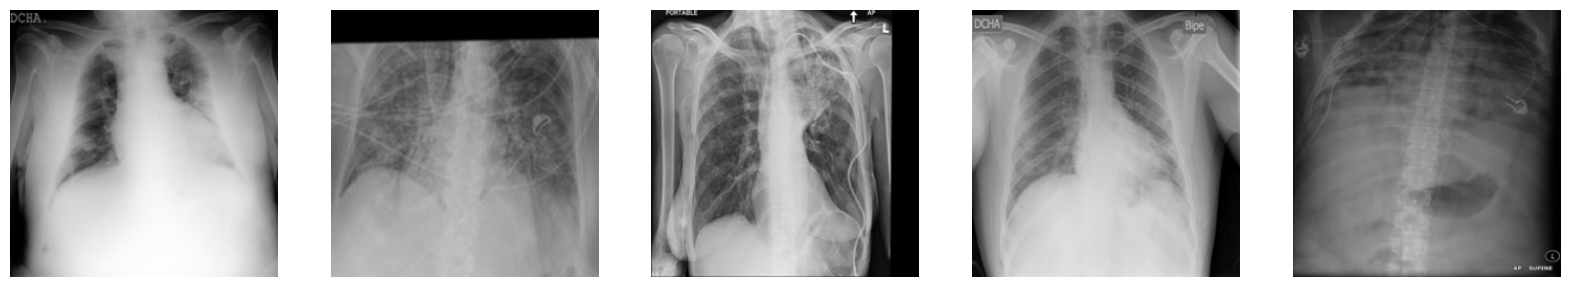

In [10]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

In [11]:
def My_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(4, activation='softmax')) # softmax

  opt=tf.keras.optimizers.Adam(1e-4)
  model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

In [12]:
model=My_CNNmodel()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,395,924 (32.03 MB)

 Trainable params: 8,395,924 (32.03 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
hist = model.fit(dataset_train, epochs=10, validation_data=dataset_test)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 137s 616ms/step - accuracy: 0.6006 - loss: 0.8875 - val_accuracy: 0.7079 - val_loss: 0.7038
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.7791 - loss: 0.5884 - val_accuracy: 0.7613 - val_loss: 0.6114
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 80s 378ms/step - accuracy: 0.8278 - loss: 0.4832 - val_accuracy: 0.7907 - val_loss: 0.5405
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 87s 404ms/step - accuracy: 0.8435 - loss: 0.4511 - val_accuracy: 0.7912 - val_loss: 0.5469
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 117s 552ms/step - accuracy: 0.8384 - loss: 0.4598 - val_accuracy: 0.8129 - val_loss: 0.4943
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 94s 434ms/step - accuracy: 0.8532 - loss: 0.4095 - val_accuracy: 0.8277 - val_loss: 0.4630
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 132s 393ms/step - accuracy: 0.8738 - loss: 0.3665 - val_accuracy: 0.8342 - val_loss: 0.4466
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 83s 388ms/step - accuracy: 0.8819 - loss

In [14]:
model.save("my_model.keras")

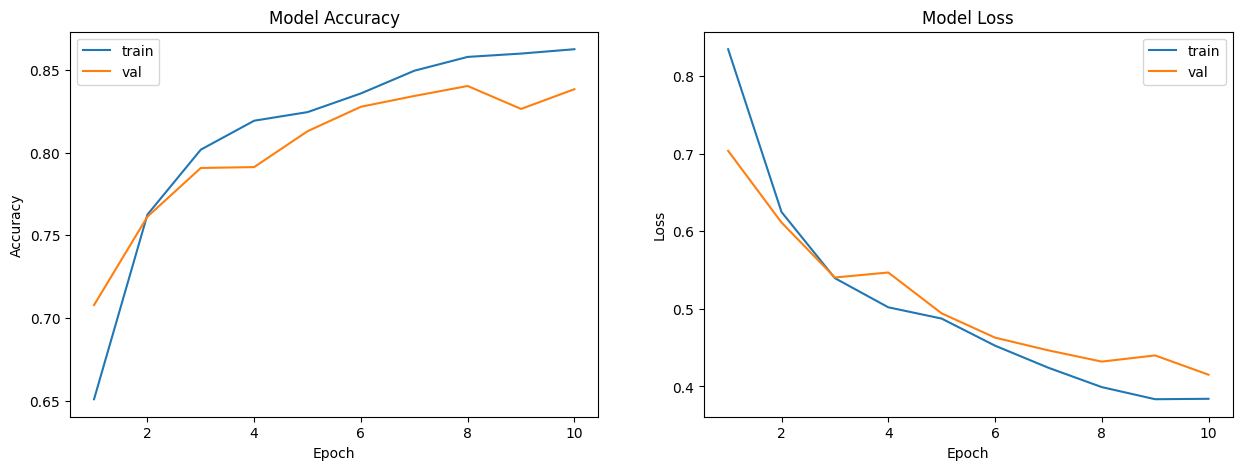

In [15]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    if val_acc in model_history.history:
        axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'] if val_acc in model_history.history else ['train'], loc='best')

    # Plot loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    if 'val_loss' in model_history.history:
        axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'] if 'val_loss' in model_history.history else ['train'], loc='best')

    plt.show()

plot_model_history(hist)

In [16]:
tf.keras.layers.Dropout(0.5)

<Dropout name=dropout, built=False>

In [17]:
tf.keras.layers.BatchNormalization()

<BatchNormalization name=batch_normalization, built=False>

202/202 ━━━━━━━━━━━━━━━━━━━━ 44s 150ms/step - accuracy: 0.8285 - loss: 0.4436
Test: accuracy = 0.837794  ;  loss = 0.417302 
202/202 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step


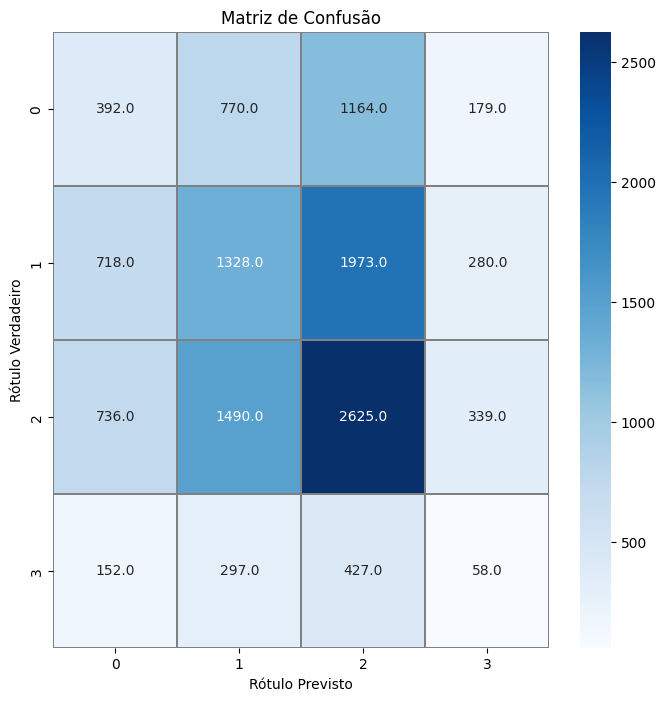

In [18]:
# Predict the values from the validation dataset
loss, accuracy = model.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
y_pred = model.predict(dataset_test)  # Predictions
y_p = np.argmax(y_pred, axis=1)
test_data=dataset_test.unbatch()
y_g=[]
for image, label in  test_data:
  y_g.append(label.numpy())

confusion_mtx = confusion_matrix(y_g, y_p)

classes = [0,1,2,3]

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax,
            xticklabels=classes , yticklabels=classes)
plt.xlabel("Rótulo Previsto")
plt.ylabel("Rótulo Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

In [19]:
report = classification_report(y_g, y_p, target_names=['0','1','2','3'])
print(report)

              precision    recall  f1-score   support

           0       0.20      0.16      0.17      2505
           1       0.34      0.31      0.32      4299
           2       0.42      0.51      0.46      5190
           3       0.07      0.06      0.06       934

    accuracy                           0.34     12928
   macro avg       0.26      0.26      0.26     12928
weighted avg       0.33      0.34      0.33     12928

